In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
import math
import librosa
import scipy.signal
import torch
from pathlib import Path
import os
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
import ot
import time
import gc
%matplotlib qt

In [2]:
def show_data_informations(signal, signal_type):
    print(f"Tipo de datos {signal_type}:", type(signal))
    print(f"Forma de los datos {signal_type}:", signal.shape)

In [3]:
EOG_all_epochs = 'EOG_all_epochs.npy'
EMG_all_epochs = 'EMG_all_epochs.npy'
EEG_all_epochs = 'EEG_all_epochs.npy'

eog_data = np.load(EOG_all_epochs)
emg_data = np.load(EMG_all_epochs)
eeg_data = np.load(EEG_all_epochs)

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Tipo de datos EOG: <class 'numpy.ndarray'>
Forma de los datos EOG: (3400, 512)
Tipo de datos EMG: <class 'numpy.ndarray'>
Forma de los datos EMG: (5598, 512)
Tipo de datos EEG: <class 'numpy.ndarray'>
Forma de los datos EEG: (4514, 512)


In [4]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]

    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

Creating RawArray with float64 data, n_channels=3, n_times=2311168
    Range : 0 ... 2311167 =      0.000 ...  4513.998 secs
Ready.
Using matplotlib as 2D backend.


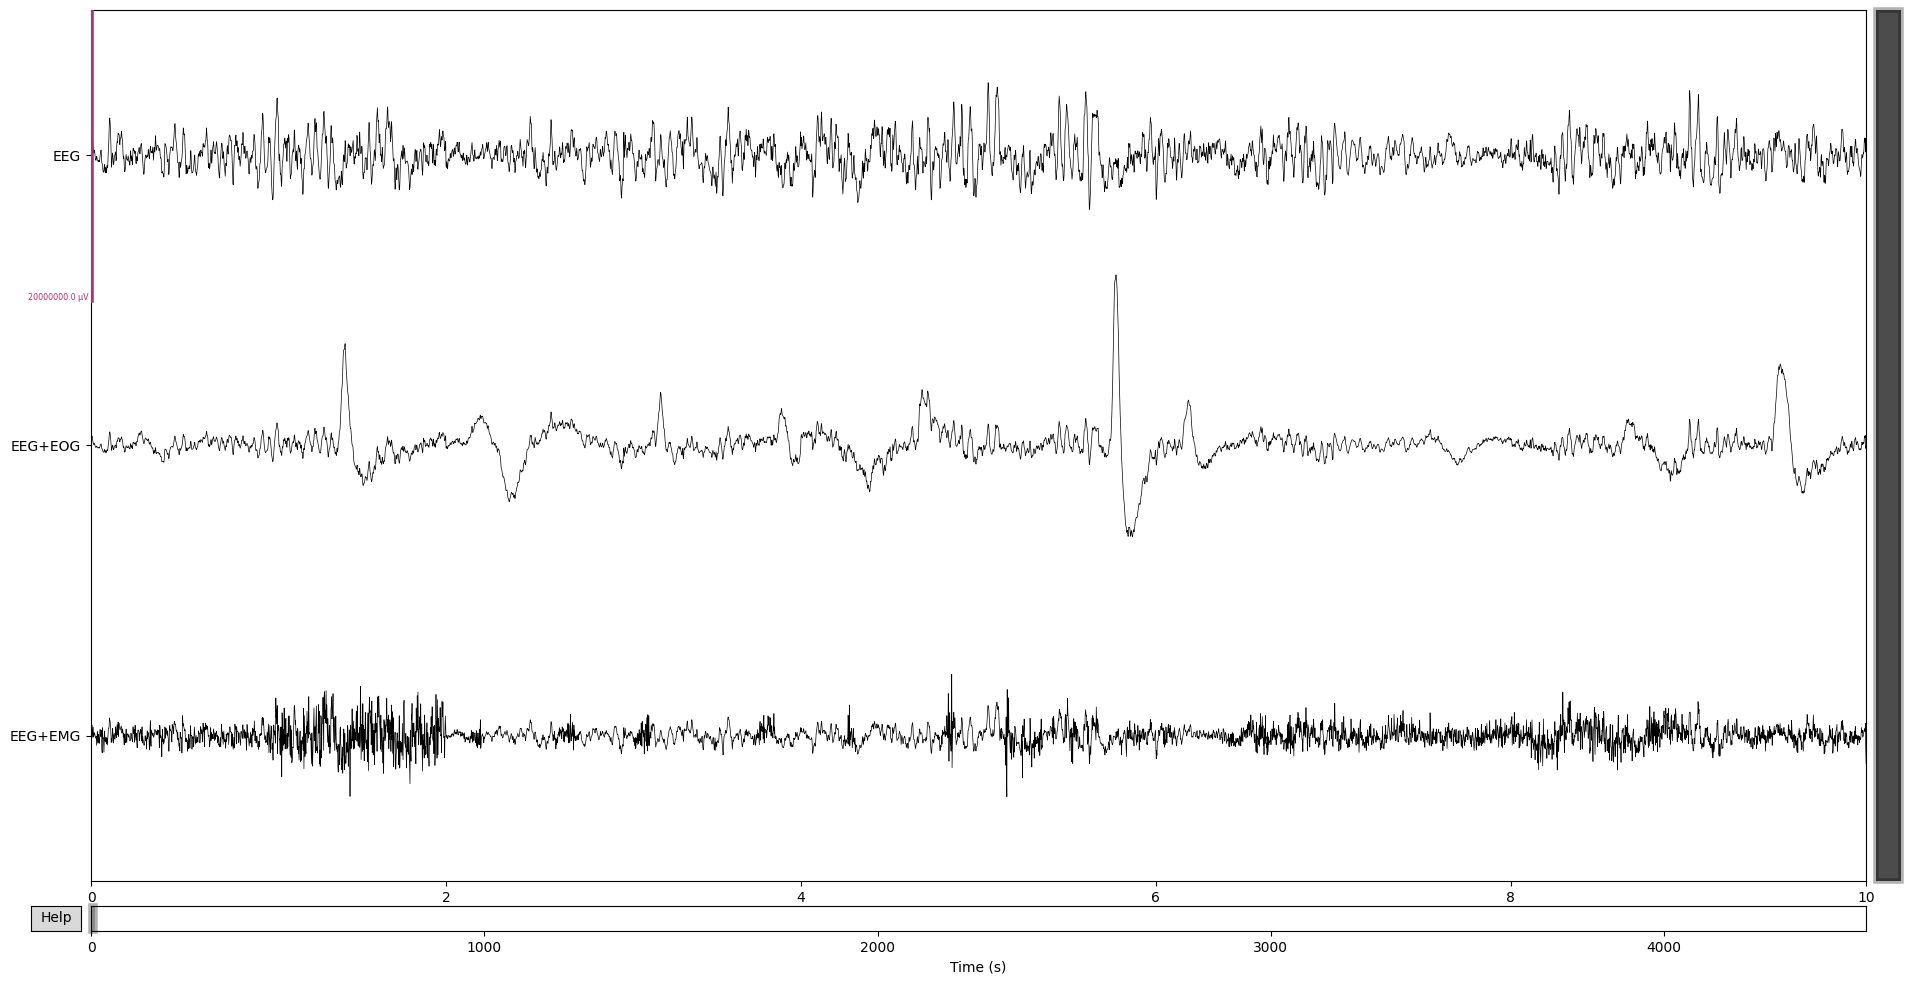

In [5]:
# Generar señales aleatorias de EEG, EOG y EMG
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))
NOISE_all_random_eog = np.squeeze(random_signal(signal=eog_data, combine_num=1))
NOISE_all_random_emg = np.squeeze(random_signal(signal=emg_data, combine_num=1))

# Generar SNR para EOG y EMG
SNR_dB_eog = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_emg = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_eog = 10 ** (0.1 * SNR_dB_eog)
SNR_emg = 10 ** (0.1 * SNR_dB_emg)

# Ajustar el tamaño de las señales de EOG y EMG
num_eeg_samples = EEG_all_random.shape[0]
num_eog_samples = eog_data.shape[0]
num_emg_samples = emg_data.shape[0]

needed_repetitions_eog = int(np.ceil(num_eeg_samples / num_eog_samples))
needed_repetitions_emg = int(np.ceil(num_eeg_samples / num_emg_samples))

# Generar ruido aleatorio para EOG y EMG
NOISE_all_random_eog = random_signal(signal=eog_data, combine_num=needed_repetitions_eog)
NOISE_all_random_emg = random_signal(signal=emg_data, combine_num=needed_repetitions_emg)

# Aplanar las señales de ruido a 2D
NOISE_all_random_eog = NOISE_all_random_eog.reshape(-1, eog_data.shape[1])
NOISE_all_random_emg = NOISE_all_random_emg.reshape(-1, emg_data.shape[1])

# Ajustar el tamaño si es necesario
if NOISE_all_random_eog.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_eog.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1).reshape(-1, eog_data.shape[1])
    NOISE_all_random_eog = np.concatenate((NOISE_all_random_eog, extra_noise), axis=0)

if NOISE_all_random_emg.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_emg.shape[0]
    extra_noise = random_signal(signal=emg_data, combine_num=1).reshape(-1, emg_data.shape[1])
    NOISE_all_random_emg = np.concatenate((NOISE_all_random_emg, extra_noise), axis=0)

# Recortar a num_eeg_samples
NOISE_all_random_eog = NOISE_all_random_eog[:num_eeg_samples]
NOISE_all_random_emg = NOISE_all_random_emg[:num_eeg_samples]

# Mezclar ruido EOG con EEG
noiseEEG_EOG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_eog = NOISE_all_random_eog[i]
    coe_eog = get_rms(eeg) / (get_rms(noise_eog) * SNR_eog[i])
    noise_eog = noise_eog * coe_eog
    noise_eeg_eog = eeg + noise_eog
    noiseEEG_EOG.append(noise_eeg_eog)

# Mezclar ruido EMG con EEG
noiseEEG_EMG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_emg = NOISE_all_random_emg[i]
    coe_emg = get_rms(eeg) / (get_rms(noise_emg) * SNR_emg[i])
    noise_emg = noise_emg * coe_emg
    noise_eeg_emg = eeg + noise_emg
    noiseEEG_EMG.append(noise_eeg_emg)

# Convertir a numpy arrays
noiseEEG_EOG = np.array(noiseEEG_EOG)
noiseEEG_EMG = np.array(noiseEEG_EMG)

# Estandarizar las señales
EEG_end_standard = EEG_all_random / np.std(EEG_all_random)
noiseEEG_EOG_standard = noiseEEG_EOG / np.std(noiseEEG_EOG)
noiseEEG_EMG_standard = noiseEEG_EMG / np.std(noiseEEG_EMG)

# Preparar datos para visualización
EEG_flat = EEG_end_standard.flatten()
noiseEEG_EOG_flat = noiseEEG_EOG_standard.flatten()
noiseEEG_EMG_flat = noiseEEG_EMG_standard.flatten()
data = np.vstack((EEG_flat, noiseEEG_EOG_flat, noiseEEG_EMG_flat))
sfreq = 512
info = mne.create_info(ch_names=['EEG', 'EEG+EOG', 'EEG+EMG'], sfreq=sfreq, ch_types=['eeg', 'eeg', 'eeg'])
raw = mne.io.RawArray(data, info)

# Graficar las señales
raw.plot(scalings=dict(eeg=10))

In [6]:
# Función para generar el espectrograma
def make_spectrum(y, feature_type='logmag', _max=None, _min=None):
    # Procesar la señal de EEG
    if y is None:
        raise ValueError("La señal EEG no puede ser None.")

    else:
        if y.dtype == 'int16':
            y = np.float32(y/32767.)
        elif y.dtype !='float32':
            y = np.float32(y)

    # Obtener la ventana Hamming
    window = scipy.signal.get_window('hamming', 512)

    # Aplicar la Transformada de Fourier de corto plazo (STFT)
    D = librosa.stft(y, center=False, n_fft=512, hop_length=160, win_length=512, window=window)
    phase = np.exp(1j * np.angle(D))
    D = np.abs(D)

    # Seleccionar el tipo de característica
    if feature_type == 'logmag':
        Sxx = np.log1p(D)
    elif feature_type == 'lps':
        Sxx = np.log10(D**2)
    else:
        Sxx = D

    return Sxx, phase, len(y)

# Función para reconstruir la señal a partir del espectrograma
def recons_spec_phase(Sxx_r, phase, length_wav, feature_type='logmag'):
    # Reconstruir la magnitud
    if feature_type == 'logmag':
        Sxx_r = np.expm1(Sxx_r)
        Sxx_r = np.clip(Sxx_r, a_min=0., a_max=None)
    elif feature_type == 'lps':
        Sxx_r = np.sqrt(10 ** Sxx_r)

    # Obtener la ventana Hamming
    window = scipy.signal.get_window('hamming', 512)

    # Multiplicar por la fase y aplicar la inversa de STFT
    R = np.multiply(Sxx_r, phase)
    result = librosa.istft(R, center=False, hop_length=160, win_length=512, window=window, length=length_wav)
    return result

In [7]:
print(EEG_flat.shape)
print(noiseEEG_EOG_flat.shape)
print(noiseEEG_EMG_flat.shape)
print(EEG_flat.dtype)
print(noiseEEG_EOG_flat.dtype)
print(noiseEEG_EMG_flat.dtype)

(2311168,)
(2311168,)
(2311168,)
float64
float64
float64


In [8]:
SxxEEG, _, _ = make_spectrum(EEG_flat)
SxxEEGEOG, _, _ = make_spectrum(noiseEEG_EOG_flat)
SxxEEGEMG, _, _ = make_spectrum(noiseEEG_EMG_flat)

In [9]:
clean_eeg_path = 'dataset/clean_eeg'
noisy_eeg_eog_path = 'dataset/noisy_eeg_eog'
noisy_eeg_emg_path = 'dataset/noisy_eeg_emg'

In [10]:
def process_and_save_spectrogram(Sxx, n_frame, out_path):
    for i in range(Sxx.shape[1] // n_frame):
        Path(out_path).mkdir(parents=True, exist_ok=True)
        out_name = os.path.join(out_path, f'{i}.pt')
        frame_data = torch.from_numpy(Sxx.transpose()[i * n_frame:(i + 1) * n_frame])
        torch.save(frame_data, out_name)
        print(f'Saved: {out_name}')

In [11]:
process_and_save_spectrogram(Sxx=SxxEEG, n_frame=64, out_path=clean_eeg_path)

Saved: dataset/clean_eeg\0.pt
Saved: dataset/clean_eeg\1.pt
Saved: dataset/clean_eeg\2.pt
Saved: dataset/clean_eeg\3.pt
Saved: dataset/clean_eeg\4.pt
Saved: dataset/clean_eeg\5.pt
Saved: dataset/clean_eeg\6.pt
Saved: dataset/clean_eeg\7.pt
Saved: dataset/clean_eeg\8.pt
Saved: dataset/clean_eeg\9.pt
Saved: dataset/clean_eeg\10.pt
Saved: dataset/clean_eeg\11.pt
Saved: dataset/clean_eeg\12.pt
Saved: dataset/clean_eeg\13.pt
Saved: dataset/clean_eeg\14.pt
Saved: dataset/clean_eeg\15.pt
Saved: dataset/clean_eeg\16.pt
Saved: dataset/clean_eeg\17.pt
Saved: dataset/clean_eeg\18.pt
Saved: dataset/clean_eeg\19.pt
Saved: dataset/clean_eeg\20.pt
Saved: dataset/clean_eeg\21.pt
Saved: dataset/clean_eeg\22.pt
Saved: dataset/clean_eeg\23.pt
Saved: dataset/clean_eeg\24.pt
Saved: dataset/clean_eeg\25.pt
Saved: dataset/clean_eeg\26.pt
Saved: dataset/clean_eeg\27.pt
Saved: dataset/clean_eeg\28.pt
Saved: dataset/clean_eeg\29.pt
Saved: dataset/clean_eeg\30.pt
Saved: dataset/clean_eeg\31.pt
Saved: dataset/cle

In [12]:
process_and_save_spectrogram(Sxx=SxxEEGEOG, n_frame=64, out_path=noisy_eeg_eog_path)

Saved: dataset/noisy_eeg_eog\0.pt
Saved: dataset/noisy_eeg_eog\1.pt
Saved: dataset/noisy_eeg_eog\2.pt
Saved: dataset/noisy_eeg_eog\3.pt
Saved: dataset/noisy_eeg_eog\4.pt
Saved: dataset/noisy_eeg_eog\5.pt
Saved: dataset/noisy_eeg_eog\6.pt
Saved: dataset/noisy_eeg_eog\7.pt
Saved: dataset/noisy_eeg_eog\8.pt
Saved: dataset/noisy_eeg_eog\9.pt
Saved: dataset/noisy_eeg_eog\10.pt
Saved: dataset/noisy_eeg_eog\11.pt
Saved: dataset/noisy_eeg_eog\12.pt
Saved: dataset/noisy_eeg_eog\13.pt
Saved: dataset/noisy_eeg_eog\14.pt
Saved: dataset/noisy_eeg_eog\15.pt
Saved: dataset/noisy_eeg_eog\16.pt
Saved: dataset/noisy_eeg_eog\17.pt
Saved: dataset/noisy_eeg_eog\18.pt
Saved: dataset/noisy_eeg_eog\19.pt
Saved: dataset/noisy_eeg_eog\20.pt
Saved: dataset/noisy_eeg_eog\21.pt
Saved: dataset/noisy_eeg_eog\22.pt
Saved: dataset/noisy_eeg_eog\23.pt
Saved: dataset/noisy_eeg_eog\24.pt
Saved: dataset/noisy_eeg_eog\25.pt
Saved: dataset/noisy_eeg_eog\26.pt
Saved: dataset/noisy_eeg_eog\27.pt
Saved: dataset/noisy_eeg_eog\2

In [13]:
process_and_save_spectrogram(Sxx=SxxEEGEMG, n_frame=64, out_path=noisy_eeg_emg_path)

Saved: dataset/noisy_eeg_emg\0.pt
Saved: dataset/noisy_eeg_emg\1.pt
Saved: dataset/noisy_eeg_emg\2.pt
Saved: dataset/noisy_eeg_emg\3.pt
Saved: dataset/noisy_eeg_emg\4.pt
Saved: dataset/noisy_eeg_emg\5.pt
Saved: dataset/noisy_eeg_emg\6.pt
Saved: dataset/noisy_eeg_emg\7.pt
Saved: dataset/noisy_eeg_emg\8.pt
Saved: dataset/noisy_eeg_emg\9.pt
Saved: dataset/noisy_eeg_emg\10.pt
Saved: dataset/noisy_eeg_emg\11.pt
Saved: dataset/noisy_eeg_emg\12.pt
Saved: dataset/noisy_eeg_emg\13.pt
Saved: dataset/noisy_eeg_emg\14.pt
Saved: dataset/noisy_eeg_emg\15.pt
Saved: dataset/noisy_eeg_emg\16.pt
Saved: dataset/noisy_eeg_emg\17.pt
Saved: dataset/noisy_eeg_emg\18.pt
Saved: dataset/noisy_eeg_emg\19.pt
Saved: dataset/noisy_eeg_emg\20.pt
Saved: dataset/noisy_eeg_emg\21.pt
Saved: dataset/noisy_eeg_emg\22.pt
Saved: dataset/noisy_eeg_emg\23.pt
Saved: dataset/noisy_eeg_emg\24.pt
Saved: dataset/noisy_eeg_emg\25.pt
Saved: dataset/noisy_eeg_emg\26.pt
Saved: dataset/noisy_eeg_emg\27.pt
Saved: dataset/noisy_eeg_emg\2

In [14]:
# Función para ordenar los archivos en base a su numeración
def load_ordered_files(data_path):
    # Listamos todos los archivos .pt en el directorio
    file_list = glob(os.path.join(data_path, '*.pt'))

    # Ordenamos los archivos basados en su nombre (ejemplo: '0.pt', '1.pt', etc.)
    ordered_files = sorted(file_list, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    #print(ordered_files)
    # Cargamos los archivos en una lista
    data = []
    for file_path in ordered_files:
        tensor = torch.load(file_path)
        data.append(tensor)

    return data

# Directorios de entrada
clean_eeg_path = 'dataset/clean_eeg'
noisy_eeg_emg_path = 'dataset/noisy_eeg_emg'
noisy_eeg_eog_path = 'dataset/noisy_eeg_eog'

# Cargamos los datos ordenados
clean_eeg_data = load_ordered_files(clean_eeg_path)
noisy_eeg_emg_data = load_ordered_files(noisy_eeg_emg_path)
noisy_eeg_eog_data = load_ordered_files(noisy_eeg_eog_path)

# Ejemplo de uso: accediendo al primer tensor de cada conjunto
print("Clean EEG data shape:", clean_eeg_data[0].shape)
print("Noisy EEG-EMG data shape:", noisy_eeg_emg_data[0].shape)
print("Noisy EEG-EOG data shape:", noisy_eeg_eog_data[0].shape)

C:\Users\iemma\AppData\Local\Temp\ipykernel_39312\1560226025.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path)


Clean EEG data shape: torch.Size([64, 257])
Noisy EEG-EMG data shape: torch.Size([64, 257])
Noisy EEG-EOG data shape: torch.Size([64, 257])


In [15]:
class EEGCustomDataset(Dataset):
    def __init__(self, clean_data, noisy_eog_data, noisy_emg_data):
        """
        Inicialización del dataset.
        :param clean_data: Lista de tensores de datos limpios (y).
        :param noisy_eog_data: Lista de tensores de datos ruidosos (X).
        :param noisy_emg_data: Lista de tensores de datos ruidosos alternativos (X_t).
        """
        self.clean_data = clean_data
        self.noisy_eog_data = noisy_eog_data
        self.noisy_emg_data = noisy_emg_data

        # Aseguramos que todas las listas tengan el mismo tamaño
        assert len(self.clean_data) == len(self.noisy_eog_data) == len(self.noisy_emg_data), \
            "Los conjuntos de datos deben tener el mismo tamaño"

    def __len__(self):
        # Devuelve el tamaño del dataset
        return len(self.clean_data)

    def __getitem__(self, idx):
        """
        Devuelve un sample del dataset.
        :param idx: Índice del sample.
        :return: Tuple (X, y, X_t) donde:
                 - X es el dato ruidoso (noisy_eeg_eog_data)
                 - y es el dato limpio (clean_eeg_data)
                 - X_t es el dato ruidoso alternativo (noisy_eeg_emg_data)
        """
        X = self.noisy_eog_data[idx]
        y = self.clean_data[idx]
        X_t = self.noisy_emg_data[idx]

        return X, y, X_t

In [16]:
eeg_dataset = EEGCustomDataset(clean_data=clean_eeg_data,
                               noisy_eog_data=noisy_eeg_eog_data,
                               noisy_emg_data=noisy_eeg_emg_data)

In [17]:
# Definimos los tamaños para cada subconjunto
total_size = len(eeg_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Dividimos el dataset en train, val y test
train_dataset, val_dataset, test_dataset = random_split(eeg_dataset, [train_size, val_size, test_size])

# Crear DataLoaders para cada subconjunto
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ejemplo de iteración sobre el DataLoader de entrenamiento
for X, y, X_t in train_loader:
    print(f"Batch X shape: {X.shape}, y shape: {y.shape}, X_t shape: {X_t.shape}")
    break

Batch X shape: torch.Size([32, 64, 257]), y shape: torch.Size([32, 64, 257]), X_t shape: torch.Size([32, 64, 257])


In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.blstm = nn.LSTM(257, 1024, dropout=0.0, num_layers=2, bidirectional=True, batch_first=True)
        self.LReLU = nn.LeakyReLU(0.3)
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=0.0)
        self.fc1 = nn.Linear(1024 * 2, 1024)
        self.fc2 = nn.Linear(1024, 257)

    def forward(self, x):
        #  x: clean mag, y: noise mag
        output, _ = self.blstm(x)
        output = self.fc1(output)
        output = self.LReLU(output)
        output = self.Dropout(output)
        output = self.fc2(output)
        output = self.ReLU(output)
        return output


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(  # input shape (batch_size, 1, 64, 257)
            nn.Conv2d(
                in_channels=1,  # input height
                out_channels=8,  # n_filters
                kernel_size=5,  # filter size
                stride=1,  # filter movement/step
                padding=2,
                # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),  # output shape (16, 28, 28)
            nn.ReLU(),  # activation
            nn.MaxPool2d(kernel_size=2),  # choose max value in 2x2 area, output shape (batch_size, 16, 32, 128)
        )
        self.conv2 = nn.Sequential(  # input shape (batch_size, 16, 32, 128)
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (batch_size, 32, 16, 64)
        )
        self.out1 = nn.Sequential(
            nn.Linear(16 * 16 * 64, 16 * 16),  # fully connected layer, output 10 classes
            nn.ReLU()  # activation
        )

        self.out2 = nn.Sequential(
            nn.Linear(16 * 16, 1),  # fully connected layer, output 10 classes
            nn.Sigmoid()  # activation
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (batch_size, 32 * 16 * 64)
        x = self.out1(x)
        output = self.out2(x)
        return output

In [19]:
def OT_loss(X_s, X_t, y_s, y_t_pred):
        N = X_s.shape[0]

        C0 = torch.cdist(X_s.reshape((N, -1)), X_t.reshape((N, -1)), p=2).cpu()
        C1 = torch.cdist(y_s.reshape((N, -1)), y_t_pred.reshape((N, -1)), p=2).cpu()

        alpha = 1  # OT source weight in loss
        beta = 1   # OT target weight in loss
        C = alpha * C0 + beta * C1

        γ = ot.emd(ot.unif(N), ot.unif(N), C.detach().numpy())
        γ = torch.from_numpy(γ).float()

        loss = torch.sum(γ * C)

        return loss

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
G = Generator().to(device)
D = Discriminator().to(device)

In [22]:
hyperparameters = {
    'NUM_EPOCHS' : 150,
    'optimizer_g' : torch.optim.Adam(G.parameters(), lr=1e-5),
    'optimizer_d' : torch.optim.Adam(D.parameters(), lr=1e-3),
    'optimizer_s' : torch.optim.Adam(G.parameters(), lr=1e-4),
    'optimizer_ot' : torch.optim.Adam(G.parameters(), lr=1e-5),
    'criterion_g' : nn.MSELoss()
}

In [23]:
LOSS_TRAIN_MSE_S = []
LOSS_VAL_MSE_S = []
LOSS_TRAIN_MSE_T = []
LOSS_VAL_MSE_T = []
TIME = []

In [24]:
for epoch in range(hyperparameters['NUM_EPOCHS']):
    start_time = time.time()
    epoch_OT_loss = 0.0
    epoch_S_loss = 0.0
    epoch_D_loss = 0.0
    epoch_G_loss = 0.0
    D.train()
    G.train()
    for batch_idx, (X_s, y_s, X_t) in enumerate(train_loader):
        X_s, y_s, X_t = X_s.to(device), y_s.to(device), X_t.to(device)
        if (batch_idx % 13 == 0):
            hyperparameters['optimizer_d'].zero_grad()
            loss_d = -torch.mean(D(y_s)) + torch.mean(D(G(X_t).detach()))
            loss_d.backward()
            hyperparameters['optimizer_d'].step()
            for p in D.parameters():
                p.data.clamp_(-0.001, 0.001)
            epoch_D_loss += loss_d.item()
        if (batch_idx % 6 == 0):
            hyperparameters['optimizer_g'].zero_grad()
            loss_g = -torch.mean(D(G(X_t)))
            loss_g.backward()
            hyperparameters['optimizer_g'].step()
            epoch_G_loss += loss_g.item()
        if (batch_idx % 2 == 0):
            loss_s = hyperparameters['criterion_g'](G(X_t), y_s)
            hyperparameters['optimizer_s'].zero_grad()
            loss_s.backward()
            hyperparameters['optimizer_s'].step()
            epoch_S_loss += loss_s.item()
        ot_loss = OT_loss(X_s, X_t, y_s, G(X_s))
        hyperparameters['optimizer_ot'].zero_grad()
        ot_loss.backward()
        hyperparameters['optimizer_ot'].step()
        epoch_OT_loss += ot_loss.item()
        # Remove features from CUDA
        del y_s, X_s, X_t
        torch.cuda.empty_cache()
        gc.collect()
    
    G.eval()
    with torch.no_grad():
        running_mse_loss_train_s = 0.0
        running_mse_loss_train_t = 0.0
        for batch_idx, (X_s, y_s, X_t) in enumerate(train_loader):
            X_s, y_s, X_t = X_s.to(device), y_s.to(device), X_t.to(device)
            outputs_s = G(X_s)
            outputs_t = G(X_t)
            mse_train_s = hyperparameters['criterion_g'](outputs_s, y_s)
            mse_train_t = hyperparameters['criterion_g'](outputs_t, y_s)
            running_mse_loss_train_s += mse_train_s.item()
            running_mse_loss_train_t += mse_train_t.item()
            del y_s, X_s, X_t, outputs_s, outputs_t
            torch.cuda.empty_cache()
            gc.collect()

    G.eval()
    with torch.no_grad():
        running_mse_loss_val_s = 0.0
        running_mse_loss_val_t = 0.0
        for batch_idx, (X_s, y_s, X_t) in enumerate(val_loader):
            X_s, y_s, X_t = X_s.to(device), y_s.to(device), X_t.to(device)
            outputs_s = G(X_s)
            outputs_t = G(X_t)
            mse_val_s = hyperparameters['criterion_g'](outputs_s, y_s)
            mse_val_t = hyperparameters['criterion_g'](outputs_t, y_s)
            running_mse_loss_val_s += mse_val_s.item()
            running_mse_loss_val_t += mse_val_t.item()
            del y_s, X_s, X_t, outputs_s, outputs_t
            torch.cuda.empty_cache()
            gc.collect()
            
    # Scores for train and validation
    epoch_time = time.time() - start_time
    TIME.append(epoch_time)
    print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds\n========================================================")
    print('Epoch %d S_MSE Train loss: %.5f T_MSE Train loss: %.5f' % 
          (epoch + 1, 
           running_mse_loss_train_s/len(train_loader),
           running_mse_loss_train_t/len(train_loader)))
    print('Epoch %d S_MSE Val loss: %.5f T_MSE Val loss: %.5f' % 
          (epoch + 1, 
           running_mse_loss_val_s/len(val_loader),
           running_mse_loss_val_t/len(val_loader)))
    
    LOSS_TRAIN_MSE_S.append(running_mse_loss_train_s/len(train_loader))
    LOSS_VAL_MSE_S.append(running_mse_loss_val_s/len(val_loader))
    LOSS_TRAIN_MSE_T.append(running_mse_loss_train_t/len(train_loader))
    LOSS_VAL_MSE_T.append(running_mse_loss_val_t/len(val_loader))
    print('\n')

Epoch 1 took 6.42 seconds
Epoch 1 S_MSE Train loss: 2.88185 T_MSE Train loss: 2.68559
Epoch 1 S_MSE Val loss: 2.99418 T_MSE Val loss: 2.79754


Epoch 2 took 3.96 seconds
Epoch 2 S_MSE Train loss: 1.95170 T_MSE Train loss: 1.70345
Epoch 2 S_MSE Val loss: 2.03206 T_MSE Val loss: 1.78252


Epoch 3 took 3.99 seconds
Epoch 3 S_MSE Train loss: 1.11560 T_MSE Train loss: 1.11848
Epoch 3 S_MSE Val loss: 1.15393 T_MSE Val loss: 1.15054


Epoch 4 took 3.95 seconds
Epoch 4 S_MSE Train loss: 1.02495 T_MSE Train loss: 1.06791
Epoch 4 S_MSE Val loss: 1.04463 T_MSE Val loss: 1.08249


Epoch 5 took 3.83 seconds
Epoch 5 S_MSE Train loss: 0.92371 T_MSE Train loss: 0.93158
Epoch 5 S_MSE Val loss: 0.95444 T_MSE Val loss: 0.95946


Epoch 6 took 4.12 seconds
Epoch 6 S_MSE Train loss: 0.91655 T_MSE Train loss: 0.90556
Epoch 6 S_MSE Val loss: 0.95756 T_MSE Val loss: 0.94485


Epoch 7 took 3.82 seconds
Epoch 7 S_MSE Train loss: 0.88645 T_MSE Train loss: 0.87439
Epoch 7 S_MSE Val loss: 0.92657 T_MSE Val loss: 0.

KeyboardInterrupt: 

In [ ]:
epochs = range(1, len(LOSS_TRAIN_MSE_S) + 1)
plt.figure(figsize=(10, 6))

plt.plot(epochs, LOSS_TRAIN_MSE_S, label='Train MSE S', marker='o')
plt.plot(epochs, LOSS_VAL_MSE_S, label='Validation MSE S', marker='o')
plt.plot(epochs, LOSS_TRAIN_MSE_T, label='Train MSE T', marker='o')
plt.plot(epochs, LOSS_VAL_MSE_T, label='Validation MSE T', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss for S and T')
plt.legend()
plt.grid()

plt.show()